In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean 
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy as sp
import scipy.special 
import seaborn as sns
import scipy.ndimage
from matplotlib.gridspec import GridSpec
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':20})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{mathrsfs}')
from matplotlib.gridspec import GridSpec

In [4]:
RC = {'figure.figsize':(10,5),
      'axes.facecolor':'white',
      'axes.edgecolor':' .15',
      'axes.linewidth':' 1.25',
      'axes.grid' : True,
      'grid.color': '.8',
      'font.size' : 15,
     "xtick.major.size": 4, "ytick.major.size": 4}

plt.rcParams.update(RC)
sns.set_palette(sns.color_palette('dark'), n_colors=None, desat=None, color_codes=False)

In [5]:
#Define non-dimensional parameters for the simulation 
Re = 2.478883e+03 
Fr = 1.105914e+00
Ri = 1/((Fr/(2*np.pi)))**2
Pr = 7
ch = 50 #input column height

In [6]:
#Define dimensionless functions f and g from equations (2.14) and (2.15) in the manuscript
#These can be easily modified by the user
a = 1
b = 0.8
c = 0.9
d = 0.9 
def f(x):
    return 19/8 + 11/8*np.tanh(a*np.log(x)-b)

def g(x):
    return 2 + np.tanh(c*np.log(x)-d)

In [7]:
#Model name
model = 'pcnn_chi'
dns_data_loc = '../data/DNS_data/Pr7_decaying/'
output_loc = '../data/PCNN_chi/'

In [8]:
t = ['T=0.5','T=1', 'T=2', 'T=4', 'T=6', 'T=7.7']
xdim, zdim = 500, 500
gf = scipy.ndimage.gaussian_filter
dudz, drdz, drtdz, chi, empirical_chi, isotropic_chi, pcnn_chi, pcnn_mean_chi, T, reb = [], [],[], [],[], [], [], [], [], []
count = 0
for i in range(0,6): #Choose timestep(s) to load here (from the list 't' above)
    T.append(t[i]) #
    dudz.append(np.load(dns_data_loc+ T[count]+'/dudz.npy').reshape((xdim,zdim)))
    drdz.append(np.load(dns_data_loc+ T[count]+'/drdz.npy').reshape((xdim,zdim)))
    drtdz.append(np.load(dns_data_loc+ T[count]+'/drtdz.npy').reshape((xdim,zdim)))
    chi.append(np.load(dns_data_loc + T[count] +'/chi.npy').reshape((xdim,zdim)))
    eps = np.load(dns_data_loc + T[count] +'/eps.npy').reshape((xdim,zdim))
    reb.append(np.mean(eps)*Re/Ri)
    isotropic_chi.append(3*(drdz[count]))
    empirical_chi.append(g(np.mean(dudz[count], axis=1)*Re/Ri)[:, None]*(drdz[count]))
    pcnn_chi.append(np.load(output_loc+model+'_sample_'+T[count]+'.npy'))
    pcnn_mean_chi.append(np.load(output_loc+model+'_means_'+T[count]+'.npy').reshape((xdim,zdim)))
    count+=1

In [9]:
print(T)

['T=0.5', 'T=1', 'T=2', 'T=4', 'T=6', 'T=7.7']


In [10]:
maes_iso = []
maes_emp = []
maes_sample = []
maes_ensemble = []

column_iso = []
column_emp = []
column_sample = []
column_ensemble = []

mean = []
mean_surr=[]
mean_surr2=[]
for i in range(len(T)):
    maes_ensemble.append(np.mean(abs(10**pcnn_mean_chi[i].reshape(xdim,zdim).T - (chi[i]).reshape(xdim,zdim).T)))
    maes_sample.append(np.mean(abs(10**pcnn_chi[i].reshape(xdim,zdim).T - (chi[i]).reshape(xdim,zdim).T)))
    maes_iso.append(np.mean(np.abs((isotropic_chi[i].reshape(xdim,zdim).T) -(chi[i]).reshape(xdim,zdim).T)))
    maes_emp.append(np.mean(np.abs((empirical_chi[i].reshape(xdim,zdim).T) -(chi[i]).reshape(xdim,zdim).T)))
    mean.append(np.mean(np.abs((chi[i]))))
    
    column_ensemble.append(np.mean(abs(np.mean(10**pcnn_mean_chi[i].reshape(xdim,zdim).T, axis=0)
                                       - np.mean((chi[i]).reshape(xdim,zdim).T, axis=0))))
    column_iso.append(np.mean(np.abs(np.mean((isotropic_chi[i]).reshape(xdim,zdim).T, axis=0) 
                                    -np.mean((chi[i]).reshape(xdim,zdim).T, axis=0))))
    column_emp.append(np.mean(np.abs(np.mean((empirical_chi[i]).reshape(xdim,zdim).T, axis=0) 
                                    -np.mean((chi[i]).reshape(xdim,zdim).T, axis=0))))
    column_sample.append(np.mean(abs(np.mean(10**pcnn_chi[i].reshape(xdim,zdim).T, axis=0)
                                         - np.mean((chi[i]).reshape(xdim,zdim).T, axis=0))))
    mean_surr.append(np.mean(np.mean((isotropic_chi[i]).reshape(xdim,zdim).T, axis=0)/np.mean((chi[i]).reshape(xdim,zdim).T, axis=0)))
    mean_surr2.append(np.mean(np.mean((empirical_chi[i]).reshape(xdim,zdim).T, axis=0)/np.mean((chi[i]).reshape(xdim,zdim).T, axis=0)))

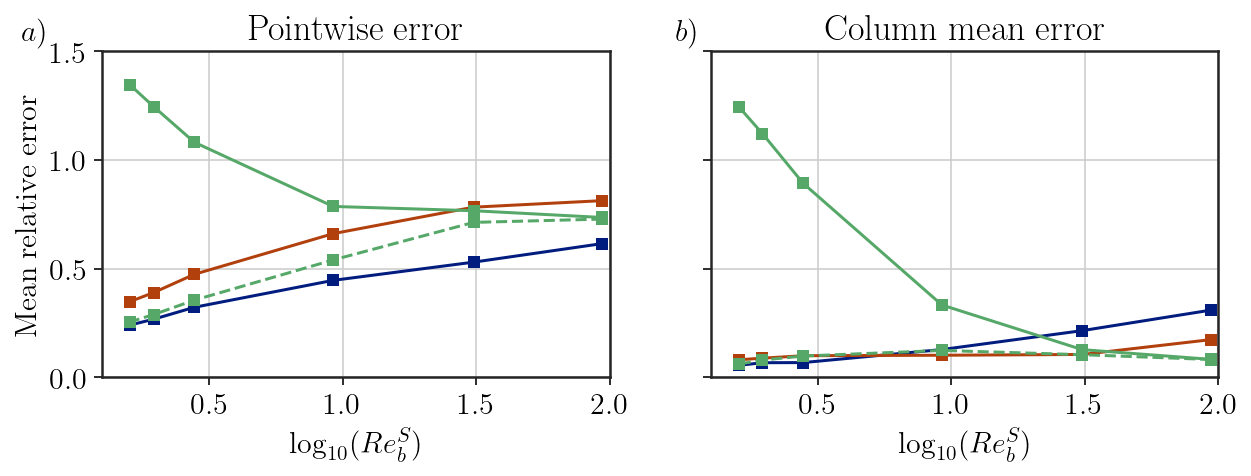

In [11]:
# plt.style.use('seaborn-whitegrid')
log_reb = np.log10(reb)
red = sns.color_palette('deep')[2]
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':15})
gs=GridSpec(1,2, width_ratios=[1,1], wspace=0.2, hspace=0.12)
fig=plt.figure(figsize=(10,3))
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 

ax1.plot(log_reb, np.array(maes_ensemble)/np.array(mean), marker='s', markersize=5, label='$\\mathrm{Model\ ensemble}$')
ax1.plot(log_reb,np.array(maes_sample)/np.array(mean), marker='s', markersize=5, label='$\\mathrm{Model\ sample}$')
ax1.plot(log_reb,np.array(maes_iso)/np.array(mean),color=red, marker='s', markersize=5, label='$\\mathrm{Surrogate}$')
ax1.plot(log_reb,np.array(maes_emp)/np.array(mean),color=red,
         marker='s', markersize=5, label='$\\mathrm{Empirical\ surrogate}$', linestyle='--')
ax1.set_xlim(0.1,2)
ax1.set_ylim(0,1.5)
ax1.annotate('$b)$', (2.25, 1.55), annotation_clip=False)
ax1.annotate('$a)$', (-0.2, 1.55), annotation_clip=False)
ax1.set_ylabel('$\\mathrm{Mean\ relative\ error }$')
ax1.set_xlabel('$\\log_{10} (Re_b^S)$')
# ax1.legend(loc='upper right')
ax1.set_title('$\\mathrm{Pointwise\ error\ }$')
ax2.plot(log_reb,np.array(column_ensemble)/np.array(mean), marker='s', markersize=5)
ax2.plot(log_reb,np.array(column_sample)/np.array(mean), marker='s', markersize=5)
ax2.plot(log_reb,np.array(column_iso)/np.array(mean),color=red, marker='s', markersize=5)
ax2.plot(log_reb,np.array(column_emp)/np.array(mean), color=red, marker='s', markersize=5, linestyle='--')
ax2.set_xlim(0.1,2)
ax2.set_ylim(0,1.5)
ax2.set_yticklabels([])
ax2.set_xlabel('$\\log_{10} (Re_b^S)$')
ax2.set_title('$\\mathrm{Column\ mean\ error\ }$')

fig.show()